# Portfolio Optimization Methods
* Monte Carlo, “brute force” style optimisation
* Scipy’s “optimize” function for “minimizing (or maximizing) objective functions, possibly subject to constraints”

# Import Required Modules

In [9]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
import datetime
import scipy.optimize as sco

import matplotlib.pyplot as plt
%matplotlib inline

# Download price data for the stocks to include in our portfolio: Apple, Microsoft, Netflix, Amazon, Google

In [10]:
tickers = ['AAPL', 'MSFT', 'NFLX', 'AMZN', 'GOOG']
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2018, 12, 31)

df = pd.DataFrame([data.DataReader(ticker, 'yahoo', start, end)['Adj Close'] for ticker in tickers]).T
df.columns = tickers

# Monte Carlo approach
#### With this approach we try to discover the optimal weights by simply creating a large number of random portfolios, all with varying combinations of constituent stock weightings, calculating and recording the Sharpe ratio of each of these randomly weighted portfolio and then finally extracting the details corresponding to the result with the highest value. The random weightings that we create will be bound by the constraint that they must be between zero and one for each of the individual stocks, and also that all the weights must sum to one to represent an investment of 100% of our theoretical capital. The more random portfolios that we create and calculate the Sharpe ratio for, theoretically the closer we get to the weightings of the “real” optimal portfolio. We will always experience some discrepancies however as we can never run enough simulated portfolios to replicate the exact weights we are searching for…we can get close, but never exact.

In [11]:
#Calculate the annualised return, annualised standard deviation and annualised Sharpe ratio of a portfolio.
#The arguments provided are, the weights of the portfolio constituents, the mean daily return of each of those constituents (as calculated over the historic data downloaded earlier), the co-variance matrix of the constituents and finally the risk free interest rate.
#The risk free rate is required for the calculation of the Sharpe ratio and should be provided as an annualised rate.
def calc_portfolio_perf(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio

#Overall creation of multiple randomly weighted portfolios
#Randomly weighted portfolios are passed to the function above to calculate the required values to record
#The values are then recorded and once all portfolios have been simulated, the results are stored in and returned as a Pandas DataFrame.
def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf):
    results_matrix = np.zeros((len(mean_returns) + 3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = calc_portfolio_perf(weights, mean_returns, cov, rf)
        results_matrix[0, i] = portfolio_return
        results_matrix[1, i] = portfolio_std
        results_matrix[2, i] = sharpe_ratio
        #iterate through the weight vector and ad data to results array
        for j in range(len(weights)):
            results_matrix[j + 3, i] = weights[j]
    results_df = pd.DataFrame(results_matrix.T, columns = ['ret', 'stdev', 'sharpe'] + [ticker for ticker in tickers])
    return results_df

In [12]:
#Calculate the mean returns and co-variance matrix of our list of stocks
#Set the number of portfolios to simulate
#Set the desired value of the risk free rate
#Call the required function and store the results in a variable to extract and visualise them.
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0.0

results_frame = simulate_random_portfolios(num_portfolios, mean_returns, cov, rf)

# Visualization
#### Below we visualise the results of all the simulated portfolios, plotting each portfolio by it’s corresponding values of annualised return (y-axis) and annualised volatility (x-axis), and also identify the 2 portfolios we are interested in. These are highlighted with a red star for the maximum Sharp ratio portfolio, and a green star for the minimum variance portfolio.

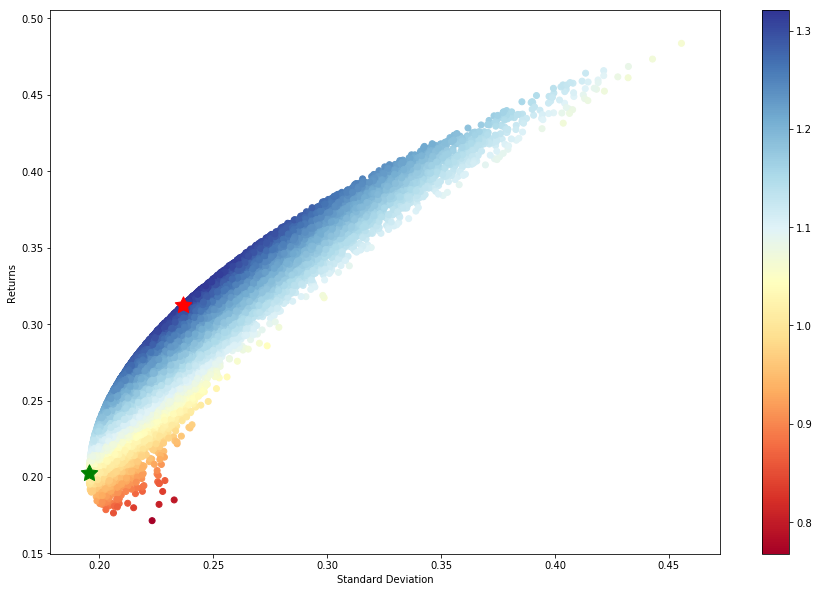

In [14]:
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_portfolio = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate position of portfolio with minimum standard deviation
min_vol_portfolio = results_frame.iloc[results_frame['stdev'].idxmin()]
#create scatter plot colored by Sharpe Ratio
plt.subplots(figsize = (15,10))
plt.scatter(results_frame.stdev, results_frame.ret, c = results_frame.sharpe, cmap = 'RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_portfolio[1], max_sharpe_portfolio[0], marker = (5, 1, 0), color = 'r', s = 300)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_portfolio[1], min_vol_portfolio[0], marker = (5, 1, 0), color = 'g', s = 300)
plt.show()